In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1095847941699218789,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15685569792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5831176210414393244
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os
from sklearn.utils import shuffle

In [3]:
IMG_PATH = '/kaggle/input/bladdercancer/new_data/'
ANNOTATION_PATH = '/kaggle/input/bladdercancer/new_data/'

input_img_paths = sorted(
    [
        os.path.join(IMG_PATH, fname)
        for fname in os.listdir(IMG_PATH)
        if fname.endswith(".png") and not fname.startswith("mask")
    ]
)
annotation_img_paths = sorted(
    [
        os.path.join(ANNOTATION_PATH, fname)
        for fname in os.listdir(ANNOTATION_PATH)
        if fname.endswith(".png") and fname.startswith("mask")
    ]
)

print(len(input_img_paths), len(annotation_img_paths))

4800 4800


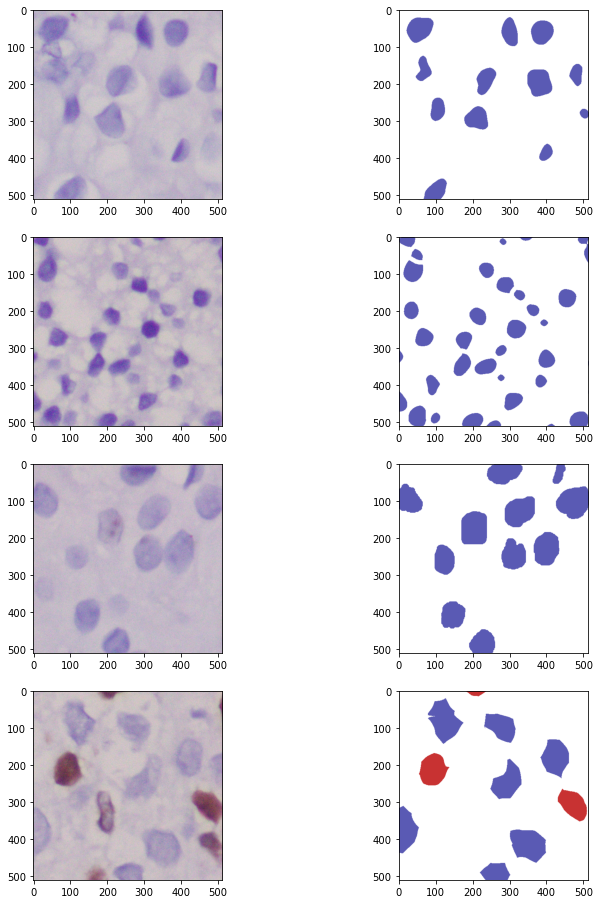

In [4]:
num_example_to_display = 4
sample_idxs = np.random.randint(0, len(input_img_paths)-1, size=(num_example_to_display,))
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i,sample_idx in enumerate(sample_idxs):
    img = Image.open(input_img_paths[sample_idx])
    mask = Image.open(annotation_img_paths[sample_idx])

    axs[i][0].imshow(img);
    axs[i][1].imshow(mask);
    # print(np.unique(mask),sample_idx)

In [6]:
def scale_down(image, mask):
  # apply scaling to image and mask
    image = tf.cast(image, tf.uint16)
    mask = tf.math.reduce_sum(mask,axis = 2)
    s = tf.where(mask == 300,0.0,mask)
    s = tf.where(s == 360,1.0,s)
    s = tf.where(s == 765,2.0,s)
    mask = tf.cast(s, tf.int32)
    mask = tf.one_hot(mask,3)
    return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
   # load the image and resize it
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = scale_down(img, mask)

    return img, mask

In [7]:
IMG_SHAPE = 512
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

# shuffle the paths and prepare train-test split
num_train = 1200
num_val = 200
input_img_paths, annotation_img_paths = shuffle(input_img_paths, annotation_img_paths)
input_img_paths_train, annotation_img_paths_train = input_img_paths[:num_train], annotation_img_paths[:num_train]
input_img_paths_val, annotation_img_paths_val = input_img_paths[num_train:num_train+num_val], annotation_img_paths[num_train:num_train+num_val]
input_img_paths_test, annotation_img_paths_test = input_img_paths[num_train+num_val:], annotation_img_paths[num_train+num_val:]


trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
valloader = tf.data.Dataset.from_tensor_slices((input_img_paths_val, annotation_img_paths_val))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))
trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valloader = (
    valloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [8]:
def class2color(img):
    img = np.argmax(img, axis = 2)
    color_img = np.zeros((512,512,3),dtype = np.int32)
    dict_map = {0: [200,50,50], 1:[90,90,180],2:[255,255,255]}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            color_img[i][j] = dict_map[int(img[i][j])]

    return color_img

## Metrics

In [51]:
from keras import backend as K

def dice_coef(y_true, y_pred, axis = [1,2,3], smooth = 1e-7, background = True):
#     y_true = K.one_hot(K.argmax(y_true,3),3)
#     y_pred = K.one_hot(K.argmax(y_pred,3),3)
    if background == False:
        y_true = y_true[:,:,:,:2]
        y_pred = y_pred[:,:,:,:2]
    intersection = K.sum(y_true * y_pred, axis)
    denom = K.sum(y_true,axis) + K.sum(y_pred, axis)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return K.mean(dice)

def soft_dice_loss(y_true,y_pred,axis = [1,2],epsilon = 1e-7):
    intersection = K.sum(y_true * y_pred,axis)
    denom = K.sum(y_true**2,axis) + K.sum(y_pred**2,axis)
    return 1 - K.mean(((2. * intersection + epsilon) / (denom + epsilon)))

def iou_coef(y_true, y_pred, smooth=1e-7,axis = [1,2,3], background = True):
    if background == False:    
        y_true = y_true[:,:,:,:2]
        y_pred = y_pred[:,:,:,:2]
    intersection = K.sum(K.abs(y_true * y_pred), axis=axis)
    union = K.sum(y_true,axis)+K.sum(y_pred,axis)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

def iou_coef_loss(y_true,y_pred):
    return 1-iou_coef(y_true,y_pred)

def hard_dice_loss(y_true,y_pred,axis = [1,2],epsilon = 1e-7):
    return 1 - dice_coef(y_true, y_pred)

def cceloss(y_true, y_pred):
    weights = np.array([135, 8, 1])
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

# Model: Separable U-Net

In [10]:
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D,Conv2DTranspose,concatenate, SeparableConv2D

IMG_SHAPE = 512

class SegmentationModel:
    '''
        Build Mobile U-Net
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        # Encoder 
        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        # Decoder
        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(512, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        # Notice OUTPUT_CHANNEL and activation
        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv  = SeparableConv2D(filters, kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv  = SeparableConv2D(filters, kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv  = SeparableConv2D(filters, kernel_size, activation=activation, padding=padding)(conv)

        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [52]:
model = SegmentationModel().prepare_model(3)
model.summary()

loss_fn = tf.keras.losses.CategoricalCrossentropy() 
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer=opt, loss = "categorical_crossentropy", metrics=["categorical_accuracy",dice_coef,iou_coef])

callback = tf.keras.callbacks.ModelCheckpoint('UNet.h5', save_best_only=True, monitor='val_loss', verbose=1)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d_104 (Separable (None, 512, 512, 32) 155         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 512, 512, 32) 9248        separable_conv2d_104[0][0]       
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 256, 256, 32) 0           conv2d_48[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = model.fit(trainloader,  epochs = 50,  validation_data=valloader, callbacks=callback)

In [ ]:
data = history.history
f, ax = plt.subplots(2,2, figsize = (15,10))
ax = ax.ravel()
ax[0].plot(data['loss'])
ax[0].plot(data['val_loss'])
ax[0].legend(['Train loss','Val loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Score')

ax[1].plot(data['categorical_accuracy'])
ax[1].plot(data['val_categorical_accuracy'])
ax[1].legend(['Train Acc','Val Acc'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Score')

ax[2].plot(data['dice_coef'])
ax[2].plot(data['val_dice_coef'])
ax[2].legend(['Train Dice','Val Dice'])
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Score')

ax[3].plot(data['iou_coef'])
ax[3].plot(data['val_iou_coef'])
ax[3].legend(['Train IoU','Val IoU'])
ax[3].set_xlabel('Epochs')
ax[3].set_ylabel('Score')
plt.show()

In [ ]:
model.save_weights('Unet_final.h5')

In [53]:
model.load_weights('/kaggle/input/unet-weights/Unet_final.h5')

## Class averaged Dice score

In [42]:
model.evaluate(trainloader)
model.evaluate(valloader)
model.evaluate(testloader);

213/213 [==============================] - 53s 246ms/step - loss: 0.1881 - categorical_accuracy: 0.9750 - dice_coef: 0.8266 - iou_coef: 0.7896


In [46]:
model.evaluate(trainloader)
model.evaluate(valloader)
model.evaluate(testloader);

213/213 [==============================] - 53s 248ms/step - loss: 0.1881 - categorical_accuracy: 0.9750 - dice_coef: 0.7481 - iou_coef: 0.7001


## Overall Dice score

In [55]:
model.evaluate(trainloader)
model.evaluate(valloader)
model.evaluate(testloader);

213/213 [==============================] - 53s 248ms/step - loss: 0.1881 - categorical_accuracy: 0.9750 - dice_coef: 0.9733 - iou_coef: 0.9494


In [50]:
eval_train = model.evaluate(trainloader)
eval_val = model.evaluate(valloader)
eval_test = model.evaluate(testloader);

213/213 [==============================] - 52s 244ms/step - loss: 0.1881 - categorical_accuracy: 0.9750 - dice_coef: 0.9203 - iou_coef: 0.8618


In [115]:
for i, ele in enumerate(testloader):
    raw, gt = ele[0], ele[1]
    if i:
        break

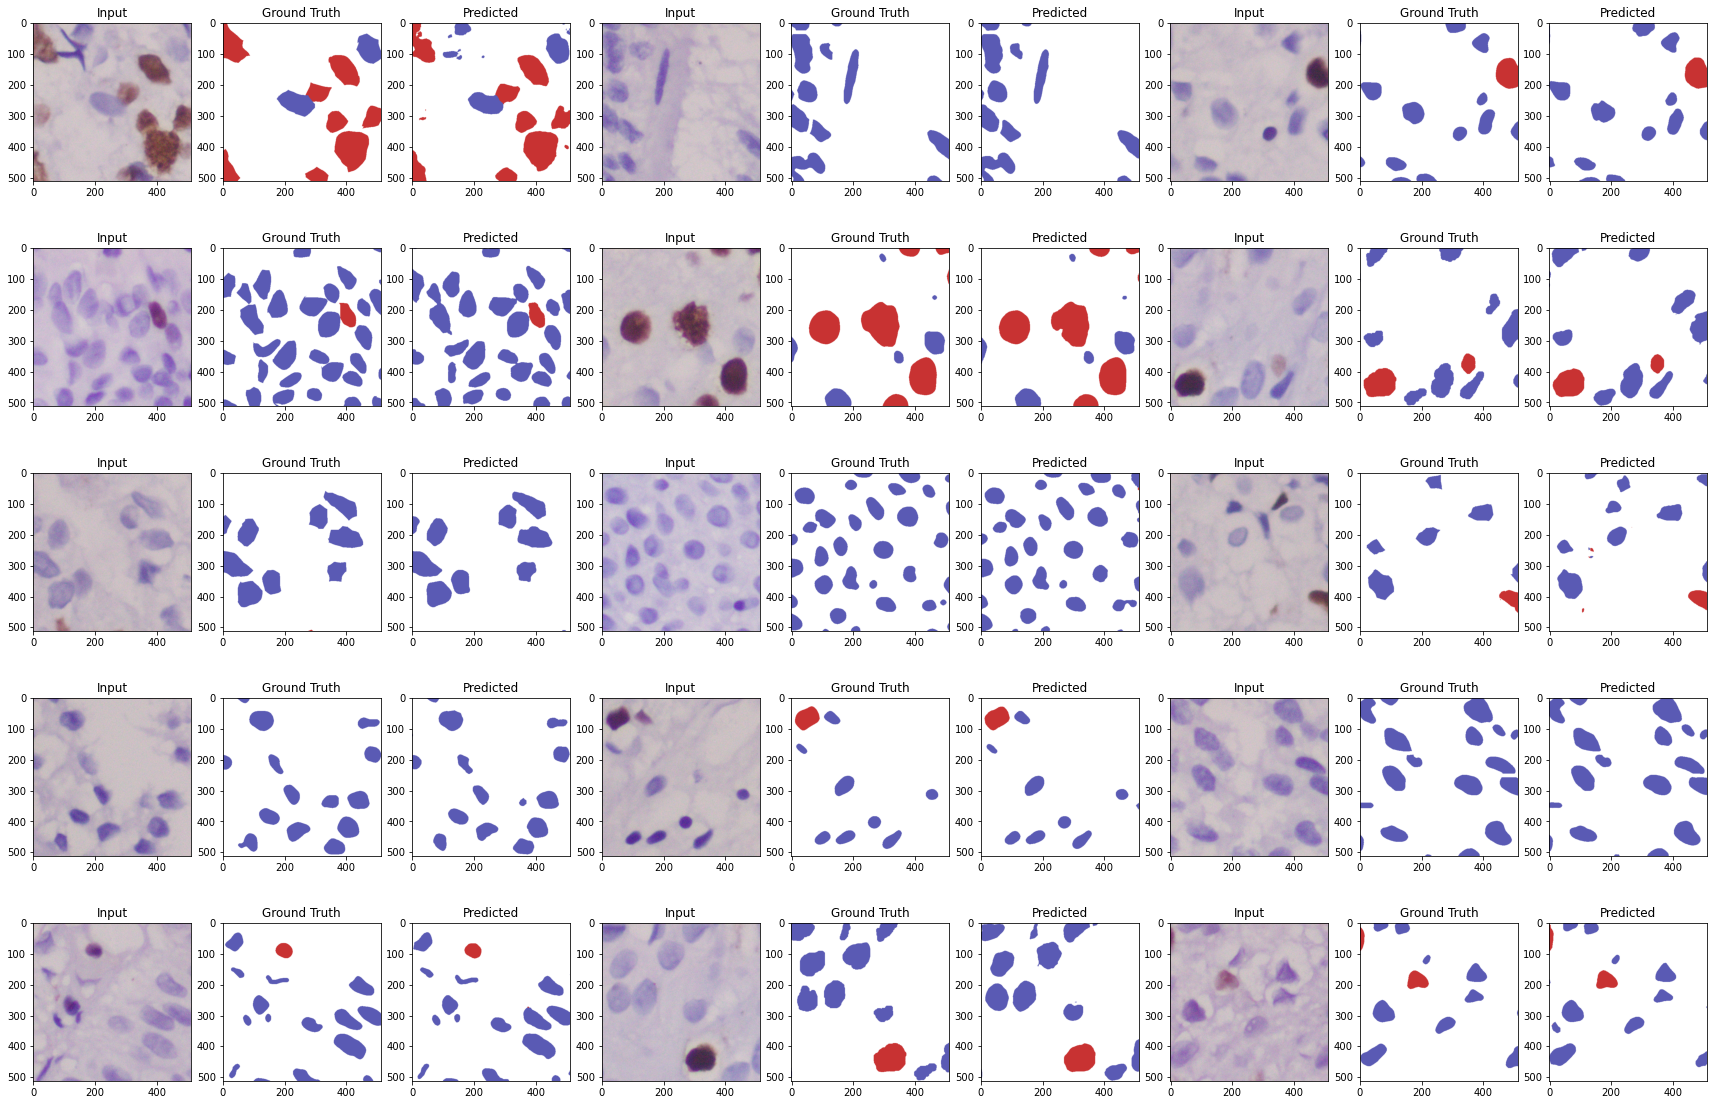

In [119]:
fig,axs = plt.subplots(5, 9,figsize = (30,20))
axs = axs.ravel()
# raw, gt = next(iter(testloader))
pred = model.predict(raw)
for i in range(15):
    axs[3*i].imshow(np.array(raw[i]))
    axs[3*i + 1].imshow(class2color(gt[i]))
    axs[3*i + 2].imshow(class2color(pred[i]))
    axs[3*i].set_title('Input')
    axs[3*i + 1].set_title('Ground Truth')
    axs[3*i + 2].set_title('Predicted')
plt.savefig('Results.png', dpi=500, facecolor = 'white', bbox_inches= 'tight')
plt.show()